#Pre-Processing of data

We have re-organized the dataset that has been provided to us. We have created two folders, "Training" and "Validation", each one containing fourteen sub-folders, one for each class of leaves that we need to recognize. We're going to use the 80% of data for the training part and the 20% of data for the validation part.


In [ ]:
# Connecting to Google Drive
from google.colab import drive
drive.mount("/gdrive")

Mounted at /gdrive


In [ ]:
# Checking the folders
%cd /gdrive/MyDrive/Colab\ Notebooks/AN2DL/Homework 1
%ls

/gdrive/MyDrive/Colab Notebooks/AN2DL/Homework 1
'AN2DL Homework 1.ipynb'   dataset.zip


In [ ]:
# Importing libraries (most of the libraries have been used in the notebooks where we really build models)
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [ ]:
# Unzipping the dataset
!unzip dataset.zip

In [ ]:
# Checking the folders
%cd /gdrive/MyDrive/Colab\ Notebooks/AN2DL/Homework 1/Post_Processed_Dataset
%ls

[Errno 2] No such file or directory: '/gdrive/MyDrive/Colab Notebooks/AN2DL/Homework 1/Post_Processed_Dataset'
/gdrive/MyDrive/Colab Notebooks/AN2DL/Homework 1
'AN2DL Homework 1.ipynb'   dataset.zip   training/


In [ ]:
dataset_dir = '/gdrive/MyDrive/Colab Notebooks/AN2DL/Homework 1/training/'

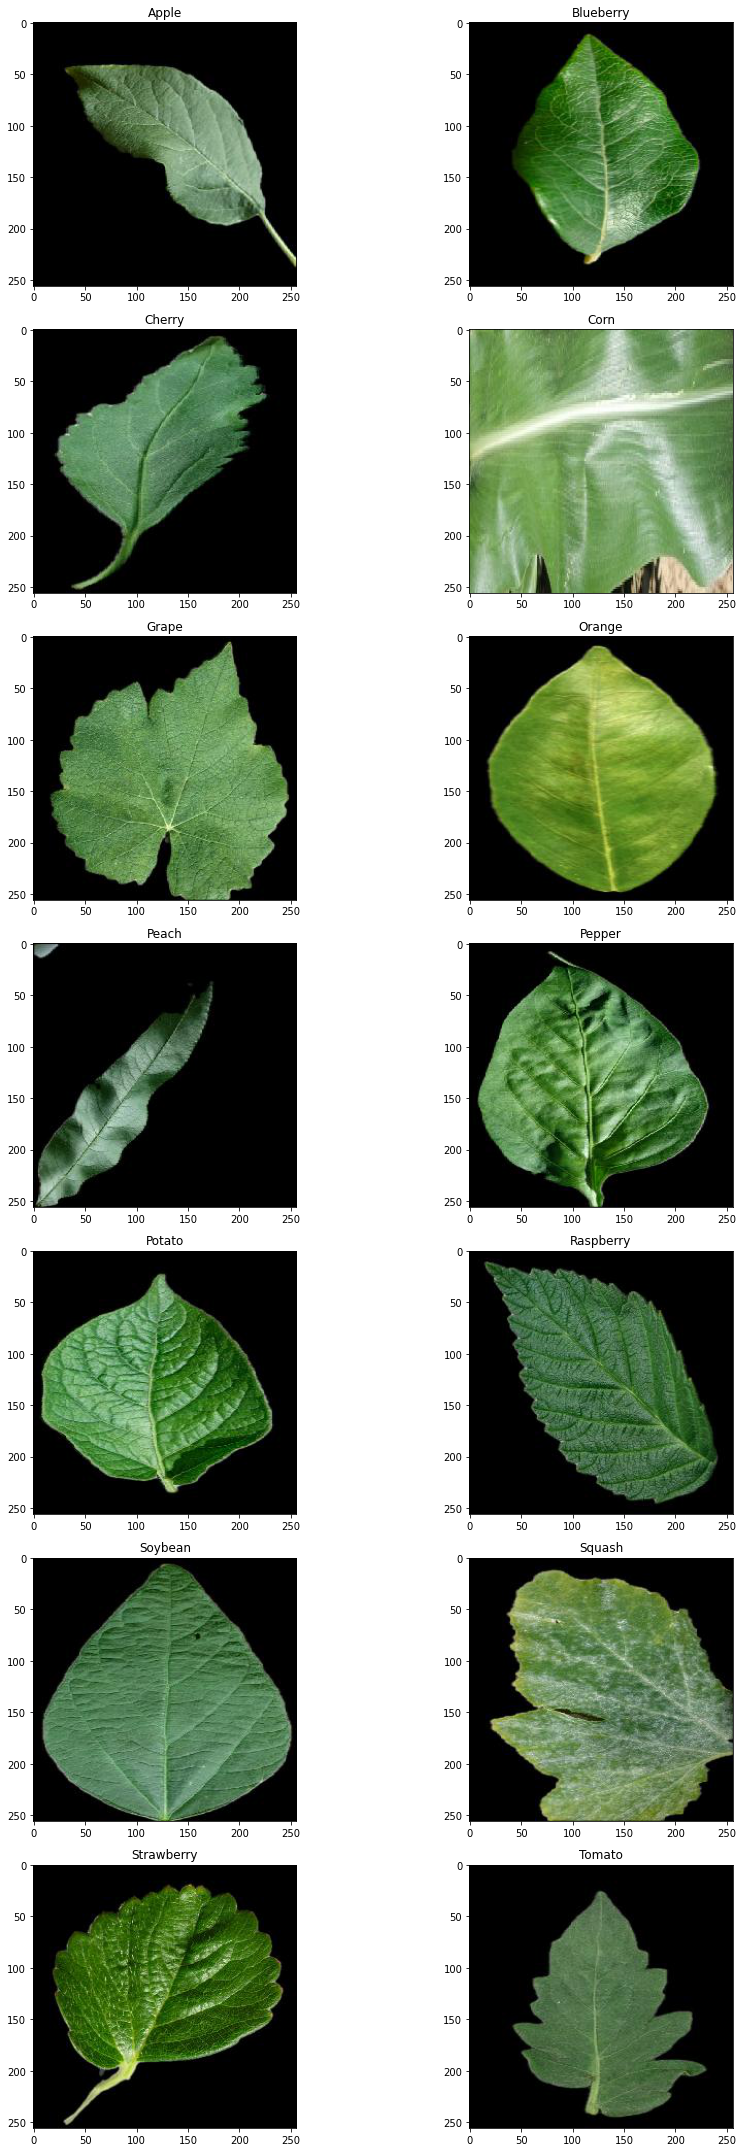

In [ ]:
# Plot example images from the dataset (to check if the unzip procedure was successful)

labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
  if i < len(labels):
    class_imgs = next(os.walk('{}/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
# Inspect dataset structure on disk

print("Depth 1 (e.g., training)")
print("------------------------")
!ls training
print()
print("Depth 2 (e.g., training/Apple)")
print("----------------------------")
!ls training/Apple

We have completed all the preliminary operations, and we're sure that the dataset has been correctly unzipped. Now we're going to re-organized the dataset that was provided to us: we will create two folders, "Training" and "Validation", each one containing fourteen sub-folders, one for each class that we need to recognize. We're going to use the 80% of data for the training part and the 20% of data for the validation part.

Creating the new folders:

In [ ]:
os.makedirs('/gdrive/MyDrive/Colab Notebooks/AN2DL/Homework 1/Post_Processed_Dataset')

In [ ]:
%cd /gdrive/MyDrive/Colab\ Notebooks/AN2DL/Homework 1
%ls

/gdrive/MyDrive/Colab Notebooks/AN2DL/Homework 1
'AN2DL Homework 1.ipynb'   dataset.zip   Post_Processed_Dataset/   training/


In [ ]:
os.makedirs('/gdrive/MyDrive/Colab Notebooks/AN2DL/Homework 1/Post_Processed_Dataset/Training')
os.makedirs('/gdrive/MyDrive/Colab Notebooks/AN2DL/Homework 1/Post_Processed_Dataset/Validation')

In [ ]:
%cd /gdrive/MyDrive/Colab\ Notebooks/AN2DL/Homework 1/Post_Processed_Dataset
%ls

/gdrive/MyDrive/Colab Notebooks/AN2DL/Homework 1/Post_Processed_Dataset
Training/  Validation/


In [ ]:
for l in labels:
  os.makedirs('/gdrive/MyDrive/Colab Notebooks/AN2DL/Homework 1/Post_Processed_Dataset/Training/' + l)

In [ ]:
for l in labels:
  os.makedirs('/gdrive/MyDrive/Colab Notebooks/AN2DL/Homework 1/Post_Processed_Dataset/Validation/' + l)

We have created all the folders that we need (they're still empty). It's now time to count how many images we have for each class in our starting dataset.

In [ ]:
import shutil

# List containing the number of images that we have in our original dataset for each class
num_of_images = []

for l in labels:
  path = '/gdrive/MyDrive/Colab Notebooks/AN2DL/Homework 1/training' + '/' + l
  numFiles = len(os.listdir(path))
  num_of_images.append(numFiles)

print(num_of_images)

[988, 467, 583, 1206, 1458, 1748, 977, 765, 716, 264, 1616, 574, 673, 5693]


We can notice an evident class imbalance: we will work whit class weights while building the models.

In [ ]:
# Computing how many images will be in the training dataset and in the validation dataset for each class considering 80/20

num_of_images_training = []
num_of_images_validation = []

for num in num_of_images:
  num_of_images_training.append(int(num*0.81))

print(num_of_images_training)

for i in range(14):
  num_of_images_validation.append(num_of_images[i]-num_of_images_training[i])

print(num_of_images_validation)

[800, 378, 472, 976, 1180, 1415, 791, 619, 579, 213, 1308, 464, 545, 4611]
[188, 89, 111, 230, 278, 333, 186, 146, 137, 51, 308, 110, 128, 1082]


In [ ]:
# Moving images from the original dataset to /Post_Processed_Dataset/Training/

path = '/gdrive/MyDrive/Colab Notebooks/AN2DL/Homework 1/training/'

for l in labels:
  num = num_of_images_training[labels.index(l)] # number of images that we need to move from the original dataset to /Post_Processed_Dataset/Training/
  for i in range(num):
    random_file=random.choice(os.listdir(path + l))
    print(random_file)
    shutil.move(path + l + '/' + random_file, '/gdrive/MyDrive/Colab Notebooks/AN2DL/Homework 1/Post_Processed_Dataset/Training/' + l)

print("Finished")

In [ ]:
# Checking how many images are present in /Post_Processed_Dataset/Training

num_of_images_post_training = []
for l in labels:
  path = '/gdrive/MyDrive/Colab Notebooks/AN2DL/Homework 1/Post_Processed_Dataset/Training' + '/' + l
  numFilesPostTraining = len(os.listdir(path))
  num_of_images_post_training.append(numFilesPostTraining)

print(num_of_images_post_training)
print(num_of_images_training)

[800, 378, 472, 976, 1180, 1415, 791, 619, 579, 213, 1308, 464, 545, 4611]
[800, 378, 472, 976, 1180, 1415, 791, 619, 579, 213, 1308, 464, 545, 4611]


In [ ]:
# Moving images from the original dataset to /Post_Processed_Dataset/Validation/

path = '/gdrive/MyDrive/Colab Notebooks/AN2DL/Homework 1/training/'

for l in labels:
  num = num_of_images_validation[labels.index(l)] # number of images that we need to move from the original dataset to /Post_Processed_Dataset/Validation/
  for i in range(num):
    random_file=random.choice(os.listdir(path + l))
    print(random_file)
    shutil.move(path + l + '/' + random_file, '/gdrive/MyDrive/Colab Notebooks/AN2DL/Homework 1/Post_Processed_Dataset/Validation/' + l)

print("Finished")

In [ ]:
# Checking how many images are present in /Post_Processed_Dataset/Validation

num_of_images_post_validation = []
for l in labels:
  path = '/gdrive/MyDrive/Colab Notebooks/AN2DL/Homework 1/Post_Processed_Dataset/Validation' + '/' + l
  numFilesPostValidation = len(os.listdir(path))
  num_of_images_post_validation.append(numFilesPostValidation)

print(num_of_images_post_validation)
print(num_of_images_validation)

[188, 89, 111, 230, 278, 333, 186, 146, 137, 51, 308, 110, 128, 1082]
[188, 89, 111, 230, 278, 333, 186, 146, 137, 51, 308, 110, 128, 1082]


If everything is okay, the original dataset should be empty

In [ ]:
# List containing the number of images for each class that we have in our original dataset post processing
num_of_images_post = []

for l in labels:
  path = '/gdrive/MyDrive/Colab Notebooks/AN2DL/Homework 1/training' + '/' + l
  numFilesPost = len(os.listdir(path))
  num_of_images_post.append(numFilesPost)

print(num_of_images_post)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Now we have images organized in the way we wanted them. From this point on, we moved to Kaggle, where GPUs help us for a faster training.